
# RAG RusLaw Demo Notebook

Оглавление:
1. [Импорт библиотек](#0-setup)
2. [Загрузка среза](#1-load)
3. [Чанкинг](#2-chunking)
4. [Построение индексов](#3-index)
5. [Retrieval demo](#4-retrieval)
6. [Метрики](#5-metrics)
7. [Визуализация метрик](#6-visualization)
8. [(Опционально) RAG-ответ с цитатами](#7-rag)
9. [Выводы для отчёта](#8-takeaways)

Все шаги офлайн по умолчанию; LLM вызовы отключены флагом `RUN_LLM`.


## 0. Импорт библиотек <a id='0-setup'></a>
- Инициализация логирования
- Базовые параметры демо (можно менять прямо в ячейке)
- Проверка наличия локального среза


In [9]:

import os
import sys
import time
from pathlib import Path
from itertools import islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rag.logging import setup_logging
from rag.ingest.load_dataset import load_documents_from_slice
from rag.ingest.chunking import chunk_documents
from rag.cli.retrieve_cli import build_retrievers
from rag.embeddings.st import SentenceTransformerEmbeddings
from rag.eval.metrics_loader import load_metrics_from_results
from rag.index.contracts import RetrievedChunk
from rag.rag_pipeline.generate import rag_answer, format_context

setup_logging()

SLICE_PATH = Path("../data/raw/ruslawod_slice.jsonl.gz")
N_DOCS = 200
CHUNK_SIZE_CHARS = int(os.getenv("CHUNK_SIZE_CHARS", 4096))
OVERLAP_CHARS = int(os.getenv("OVERLAP_CHARS", 128))
MIN_CHUNK_CHARS = int(os.getenv("MIN_CHUNK_CHARS", 50))
RETRIEVERS_TO_BUILD = ["bm25", "dense", "hybrid"]
K = 10
EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL") or os.getenv("EMBEDDING_MODEL_DEFAULT") or "intfloat/multilingual-e5-small"
EMBEDDING_BATCH_SIZE = int(os.getenv("EMBEDDING_BATCH_SIZE", 32))
RUN_LLM = False  # установите True и задайте ключ/модель, если хотите вызвать LLM
QUERY_EXAMPLES = [
    "налог на доходы физических лиц",
    "расторжение брачного договора",
    "избирательные права граждан",
]

print(f"Python: {sys.version.split()[0]}")
print(f"Slice path exists: {SLICE_PATH.exists()}")
print(f"Embedding model: {EMBEDDING_MODEL}")

%load_ext autoreload
%autoreload 2


Python: 3.11.12
Slice path exists: True
Embedding model: intfloat/multilingual-e5-small
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Загрузка среза RusLawOD <a id='1-load'></a>
Читаем нормализованный gzip JSONL и смотрим несколько документов.


In [10]:

if not SLICE_PATH.exists():
    raise FileNotFoundError("Сначала соберите локальный срез: make hf-slice")

start = time.time()
documents = load_documents_from_slice(SLICE_PATH)
elapsed = time.time() - start
print(f"Документов: {len(documents)}, время загрузки: {elapsed:.2f}s")

preview_rows = []
for doc in islice(documents, 2):
    preview_rows.append({
        "doc_id": doc.doc_id,
        "title": doc.title,
        "doc_type": doc.metadata.get("doc_type") or doc.metadata.get("doc_typeIPS"),
        "docdate": doc.metadata.get("docdate") or doc.metadata.get("docdateIPS"),
        "text_len": len(doc.text),
    })
display(pd.DataFrame(preview_rows))


2025-12-26 04:36:20 | INFO | rag.ingest.load_dataset | Загрузка среза: ../data/raw/ruslawod_slice.jsonl.gz, строк=10000, документов=9952, пустой текст=48


Документов: 9952, время загрузки: 0.83s


,doc_id,title,doc_type,docdate,text_len
0,102411198,О внесении изменения в порядок принятия решени...,Приказ,09.09.2016,2304
1,102142126,Об утверждении и введении в действие федеральн...,Приказ,28.06.2010,1370


## 2. Чанкинг <a id='2-chunking'></a>
Разбиваем первые `N_DOCS` документов на чанки с текущими параметрами.


2025-12-26 04:36:24 | INFO | rag.ingest.chunking | Start chunking documents (chunk_size=4096, overlap=128)
2025-12-26 04:36:24 | INFO | rag.ingest.chunking | Chunked 50 документов, всего чанков: 274


2025-12-26 04:36:24 | INFO | rag.ingest.chunking | Chunked 100 документов, всего чанков: 608
2025-12-26 04:36:24 | INFO | rag.ingest.chunking | Chunked 150 документов, всего чанков: 1061
2025-12-26 04:36:24 | INFO | rag.ingest.chunking | Chunked 200 документов, всего чанков: 1471
2025-12-26 04:36:24 | INFO | rag.ingest.chunking | Chunking завершён: 200 документов → 1471 чанков


Чанков: 1471 из 200 документов, время: 0.08s
{'min': 2, 'p50': 381, 'p90': 2437, 'max': 4096}


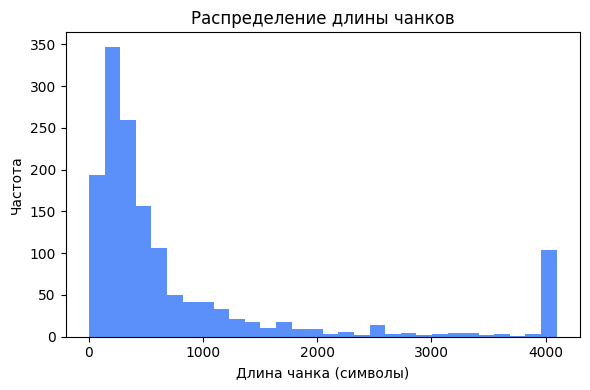

,doc_id,chunk_id,doc_type,docdate,text_preview
0,102411198,102411198_chunk_0,Приказ,09.09.2016,ФЕДЕРАЛЬНАЯ СЛУЖБА ПО ВОЕННО-ТЕХНИЧЕСКОМУ СОТР...
1,102142126,102142126_chunk_0,Приказ,28.06.2010,ПРИКАЗ Министерства образования и науки Росс...
2,102117651,102117651_chunk_0,Постановление,27.10.2007,ПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ ПОСТАНОВЛ...


In [11]:
subset_docs = documents[:N_DOCS]
start = time.time()
chunks = chunk_documents(
    subset_docs,
    chunk_size_chars=CHUNK_SIZE_CHARS,
    overlap_chars=OVERLAP_CHARS,
)
elapsed = time.time() - start
print(f"Чанков: {len(chunks)} из {len(subset_docs)} документов, время: {elapsed:.2f}s")

lengths = [len(c.text) for c in chunks]
print({
    "min": int(np.min(lengths)) if lengths else 0,
    "p50": int(np.median(lengths)) if lengths else 0,
    "p90": int(np.percentile(lengths, 90)) if lengths else 0,
    "max": int(np.max(lengths)) if lengths else 0,
})

plt.figure(figsize=(6,4))
plt.hist(lengths, bins=30, color="#5b8ff9")
plt.xlabel("Длина чанка (символы)")
plt.ylabel("Частота")
plt.title("Распределение длины чанков")
plt.tight_layout()
plt.show()

example_rows = []
for ch in islice(chunks, 3):
    example_rows.append({
        "doc_id": ch.doc_id,
        "chunk_id": ch.chunk_id,
        "doc_type": ch.metadata.get("doc_type") or ch.metadata.get("doc_typeIPS"),
        "docdate": ch.metadata.get("docdate") or ch.metadata.get("docdateIPS"),
        "text_preview": ch.text[:200].replace("\n", " ") + "...",
    })
display(pd.DataFrame(example_rows))


## 3. Построение индексов <a id='3-index'></a>
Строим BM25 и, при доступной модели, Dense/Hybrid. Если модель не найдена локально и скачивание запрещено, выводим предупреждение.


In [12]:
from dotenv import load_dotenv


load_dotenv()

retrievers = {}
retriever_errors = {}

use_dense = any(r in {"dense", "hybrid"} for r in RETRIEVERS_TO_BUILD)
embedder = None
if use_dense:
    try:
        embedder = SentenceTransformerEmbeddings(
            model_name=EMBEDDING_MODEL,
            batch_size=EMBEDDING_BATCH_SIZE,
        )
    except Exception as exc:
        retriever_errors["dense"] = str(exc)
        print(f"Dense недоступен: {exc}")

try:
    retrievers = build_retrievers(
        chunks,
        use_dense=use_dense and embedder is not None,
        use_hybrid="hybrid" in RETRIEVERS_TO_BUILD and embedder is not None,
        embedder=embedder,
        min_chunk_chars=MIN_CHUNK_CHARS,
    )
    print(f"Построены retrievers: {list(retrievers.keys())}")
except Exception as exc:
    print(f"Ошибка при построении retrievers: {exc}")


2025-12-26 04:36:35 | INFO | rag.index.bm25 | Строим BM25 индекс по 1471 чанкам
2025-12-26 04:36:35 | INFO | rag.index.faiss_dense | Строим FAISS индекс по 1417 чанкам (min_len=50)
2025-12-26 04:36:35 | INFO | rag.embeddings.st | Загрузка модели эмбеддингов: intfloat/multilingual-e5-small (cache=data/cache/embeddings)
2025-12-26 04:36:35 | INFO | sentence_transformers.SentenceTransformer | Load pretrained SentenceTransformer: intfloat/multilingual-e5-small
2025-12-26 04:36:35 | WARNING | sentence_transformers.SentenceTransformer | No sentence-transformers model found with name intfloat/multilingual-e5-small. Creating a new one with mean pooling.


Ошибка при построении retrievers: Модель intfloat/multilingual-e5-small не найдена локально. Скачайте её заранее при доступе к сети или установите EMBEDDING_ALLOW_DOWNLOAD=true.


## 4. Retrieval демо <a id='4-retrieval'></a>
Выберем запрос из примеров и сравним top-k для каждого доступного retriever.


In [ ]:

QUERY = QUERY_EXAMPLES[0]
print(f"Запрос: {QUERY}")

def summarize_results(results: list[RetrievedChunk]):
    unique_docs = len({r.doc_id for r in results}) if results else 0
    coverage = unique_docs / len(results) if results else 0
    from collections import Counter
    doc_counts = Counter(r.doc_id for r in results)
    dominance = (max(doc_counts.values()) / len(results)) if results else 0
    return unique_docs, coverage, dominance

for name, retr in retrievers.items():
    res = retr.retrieve(QUERY, k=K)
    unique_docs, coverage, dominance = summarize_results(res)
    print(f"\n{name.upper()} — найдено {len(res)}, уникальных doc_id: {unique_docs}, coverage={coverage:.2f}, dominance={dominance:.2f}")
    rows = []
    for r in res:
        rows.append({
            "doc_id": r.doc_id,
            "chunk_id": r.chunk_id,
            "score": r.score,
            "doc_type": r.metadata.get("doc_type") or r.metadata.get("doc_typeIPS"),
            "docdate": r.metadata.get("docdate") or r.metadata.get("docdateIPS"),
            "title": r.metadata.get("title") or r.metadata.get("heading") or r.metadata.get("headingIPS"),
            "text_preview": (r.text or "")[:240].replace("\n", " ") + "...",
        })
    display(pd.DataFrame(rows))


## 5. Метрики <a id='5-metrics'></a>
Пробуем прочитать агрегированные метрики из `results/`. Если их нет, выводим предупреждение.


In [ ]:

from pathlib import Path

metrics_df = load_metrics_from_results(Path("results"))
if metrics_df.empty:
    print("Метрики не найдены. Сначала запустите make eval-ragas для расчёта.")
else:
    display(metrics_df.head())


## 6. Визуализация (matplotlib) <a id='6-visualization'></a>
Строим bar chart по `context_precision` и `context_recall` (или их id_based вариант) для доступных retriever.


In [ ]:

if metrics_df.empty:
    print("Пропускаем графики — нет данных.")
else:
    df = metrics_df.copy()
    df["metric_name"] = df["metric_name"].str.replace("id_based_", "", regex=False)
    for metric in ["context_precision", "context_recall"]:
        subset = df[df["metric_name"] == metric]
        if subset.empty:
            print(f"Нет данных для {metric}")
            continue
        plt.figure(figsize=(6,4))
        plt.bar(subset["retriever"], subset["mean"], yerr=subset.get("std"), capsize=5)
        plt.ylabel(metric)
        plt.xlabel("retriever")
        plt.ylim(0, 1)
        plt.title(f"{metric} по retrievers")
        plt.tight_layout()
        plt.show()


## 7*. Ответы RAG на основе источников <a id='7-rag'></a>
Этот шаг требует LLM ключей (OPENROUTER_API_KEY/OPENROUTER_MODEL) и может обращаться к сети. По умолчанию `RUN_LLM=False` — выставите True на свой риск.


In [ ]:

if RUN_LLM:
    from rag.llm.openrouter import OpenRouterClient

    def retriever_func(q: str, k: int, embedding_model: str | None):
        if not retrievers:
            return []
        first_name = next(iter(retrievers))
        return retrievers[first_name].retrieve(q, k=k)

    client = OpenRouterClient()
    response = rag_answer(
        QUERY,
        retriever_func=retriever_func,
        k=K,
        embedding_model=EMBEDDING_MODEL,
        llm_client=client,
    )
    print("Ответ:")
    display(response.answer)
    print("Citations:")
    display(pd.DataFrame(response.citations))
else:
    print("RUN_LLM=False — шаг пропущен")


## 8. Выводы <a id='8-takeaways'></a>
Заполните выводы после экспериментов:
- Какой retriever показал лучший recall/precision?
- Как влияет размер чанка и модель эмбеддингов?
- Какие ограничения текущей разметки/среза?
